## Load and Evaluate the Experiments

This notebook is an interactive testing environment for now and will be used to generate the final plots for the accompanying paper. [Paper Citation]

## 1. Import Libraries

In [8]:
# ----------------
# import libraries
# ----------------

# standard libraries
# -----
import os
import sys
import random
import datetime


import numpy as np
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
# configuration module
# -----

sys.path.append(os.path.dirname(sys.path[0]))
#import config
from config import args

# define manual random seed
torch.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

# custom libraries
# -----
from utils.general import save_model, load_model, save_args, AverageMeter, DotDict
from utils.configurator import get_augmentations, get_dataloaders, get_network, get_optimizer, get_scheduler, update_lr, get_loss
from utils.evaluation import fuse_representations, lls_fit, lls_eval, supervised_eval, knn_eval, wcss_bcss, get_pacmap, train_linear_classifier, evaluate, log_to_tensorboard
from utils.visualization import ConfusionMatrix
from utils.networks import LinearClassifier, DoubleOutput

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# macOS does do its own multiprocessing and does not like it prescribed
args.num_workers = 0 if torch.backends.mps.is_available() else args.num_workers


data_properties_dict = {
    'C3': DotDict({'rgb_mean': (0.3621, 0.3644, 0.3635),
           'rgb_std': (0.1456, 0.1479, 0.1477),
           'classes': [str(c) for c in range(0,50)],
           'n_classes': 50,
           }),
}

In [3]:
args.exp_dir = "/Users/markus/Research/Code/ColorConstancyLearning/learning/save/12-12-23_16-20__seed_0_C3_aug_time_SimCLR_reg_None"
# get the model you want to load
model_path = args.exp_dir + '/models/' + 'backbone_epoch_100.pt'
model = get_network(args, data_properties_dict).to(device)
load_model(model, model_path, device)
#model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
model.eval()

# the DoubleOutput class is just needed because the fuse_representations function
# expects an output of (representation, projection) to work within the training loop
# and an encoder method that is only part of the network - I am faking this here with
# sequential modules to extract more representations

class layer3(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        model.layer2,
                        model.layer3,
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l3 = layer3()
l3.eval()

class layer2(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        model.layer2,
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l2 = layer2()
l2.eval()

class layer1(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l1 = layer1()
l1.eval()


class layer0(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l0 = layer0()
l0.eval()

#classifier.eval()

layer0(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  )
  (out): Sequential(
    (0): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
    )
    (1): DoubleOutput()
  )
)

In [6]:
args.data_root = "/Users/markus/Research/Code/ColorConstancyLearning/learning/data"
# get the dataloaders for the dataset
dataloader_train, dataloader_train_eval, dataloader_test = get_dataloaders(
    args, data_properties_dict)

[INFO:] Training set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/train'
[INFO:] Evaluation Training set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/train'
[INFO:] Test set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/test'


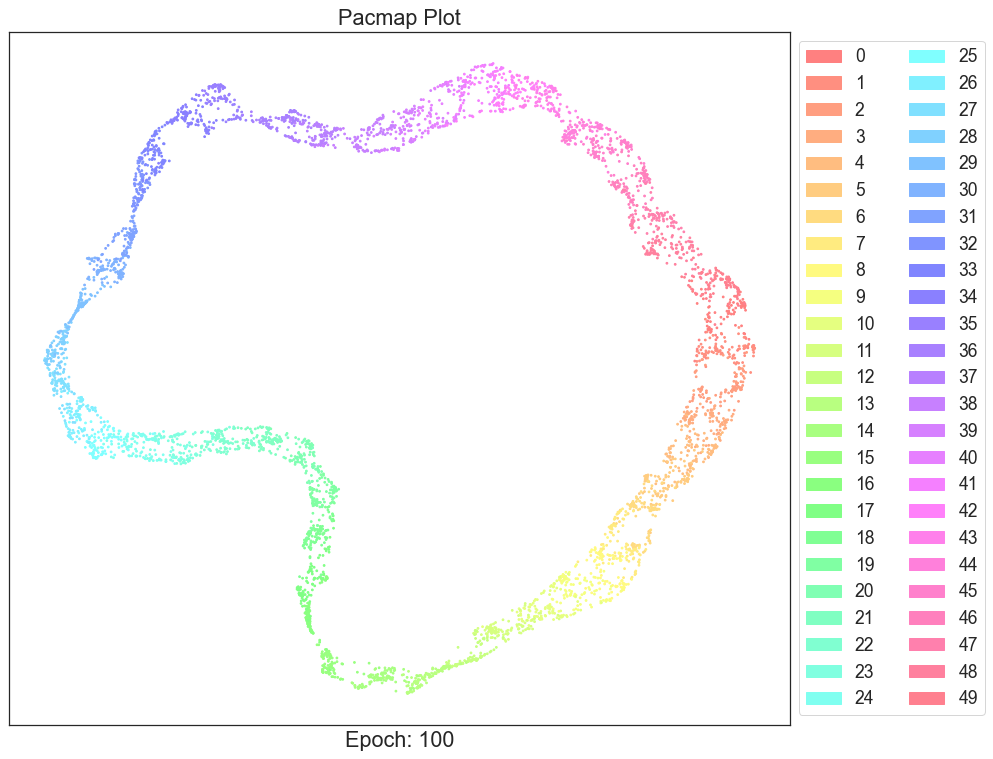

tensor(0.7308)


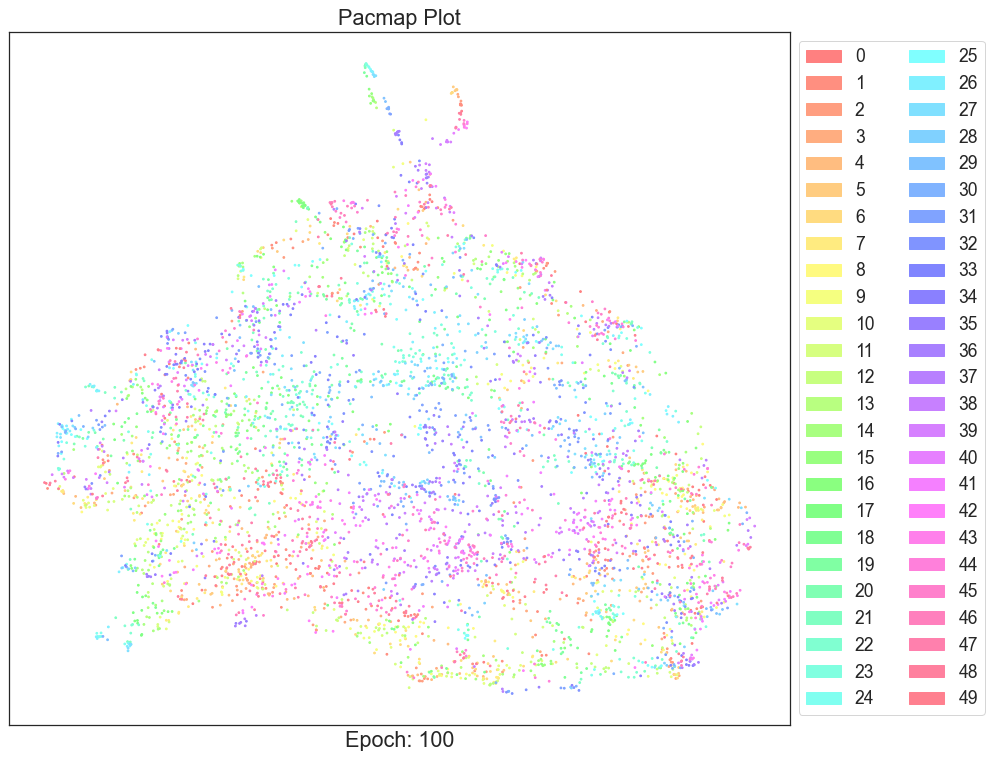

tensor(0.1946)


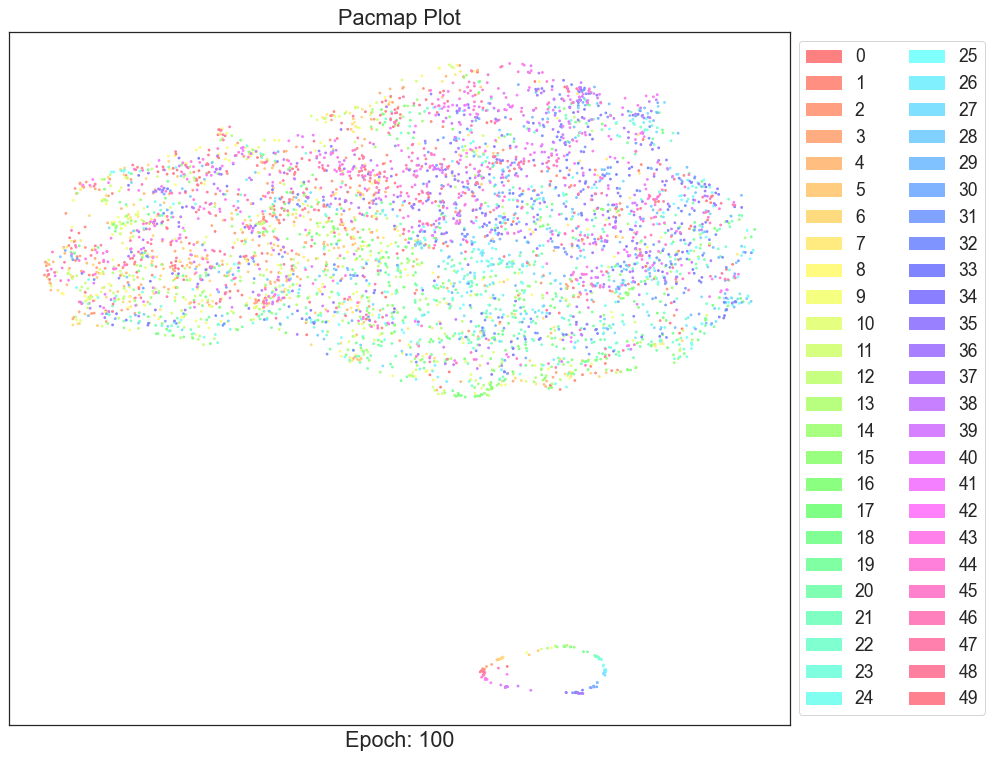

tensor(0.0768)


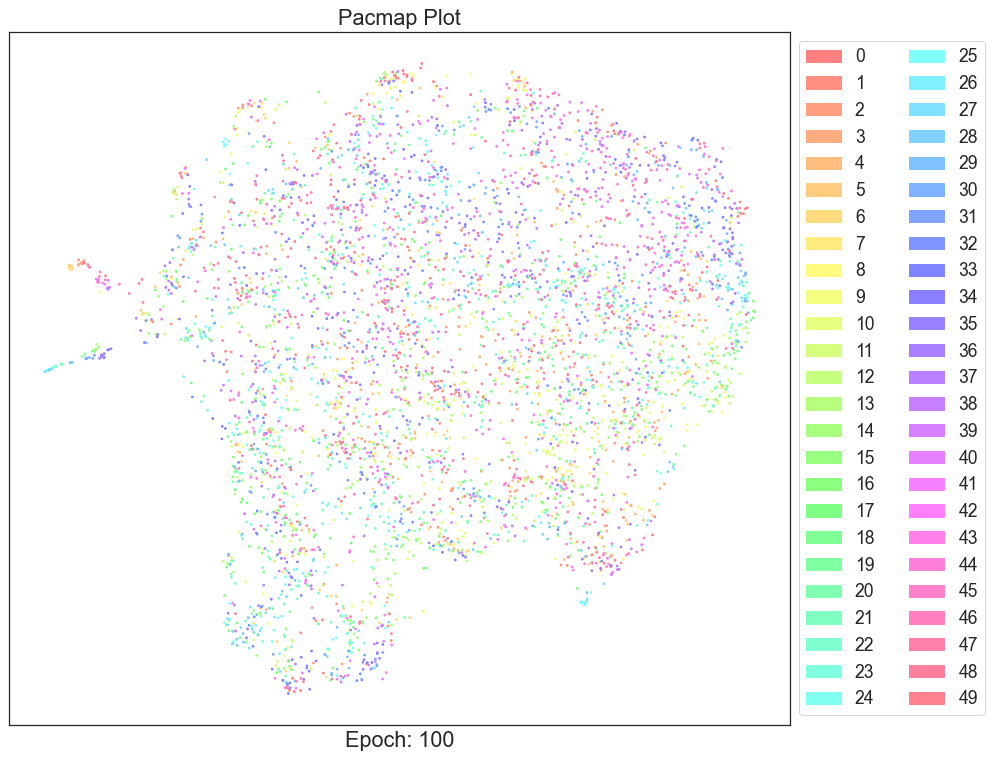

tensor(0.0768)


In [31]:
for layer in [l3, l2, l1, l0]:
# do the standard evaluation on the unsupervised representation
    features_train_eval, labels_train_eval = fuse_representations(
        layer, dataloader_train_eval, device=device)
    features_test, labels_test = fuse_representations(
        layer, dataloader_test, device=device)
    lstsq_model = lls_fit(features_train_eval,
                          labels_train_eval,
                          data_properties_dict[args.dataset].n_classes,
                          scipy=False)
    pred, test_acc = lls_eval(lstsq_model,
                              features_test,
                              labels_test)
    wb = wcss_bcss(features_test,
                   labels_test,
                   data_properties_dict[args.dataset].n_classes)
    #standard pacmap plot
    pacmap_plot = get_pacmap(
        features_test,
        labels_test,
        100,
        data_properties_dict[args.dataset].n_classes,
        data_properties_dict[args.dataset].classes)
    plt.show()
    print(test_acc)


0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000
1000 1100
1100 1200
1200 1300
1300 1400
1400 1500
1500 1600
1600 1700
1700 1800
1800 1900
1900 2000
2000 2100
2100 2200
2200 2300
2300 2400
2400 2500
2500 2600
2600 2700
2700 2800
2800 2900
2900 3000
3000 3100
3100 3200
3200 3300
3300 3400
3400 3500
3500 3600
3600 3700
3700 3800
3800 3900
3900 4000
4000 4100
4100 4200
4200 4300
4300 4400
4400 4500
4500 4600
4600 4700
4700 4800
4800 4900
4900 5000


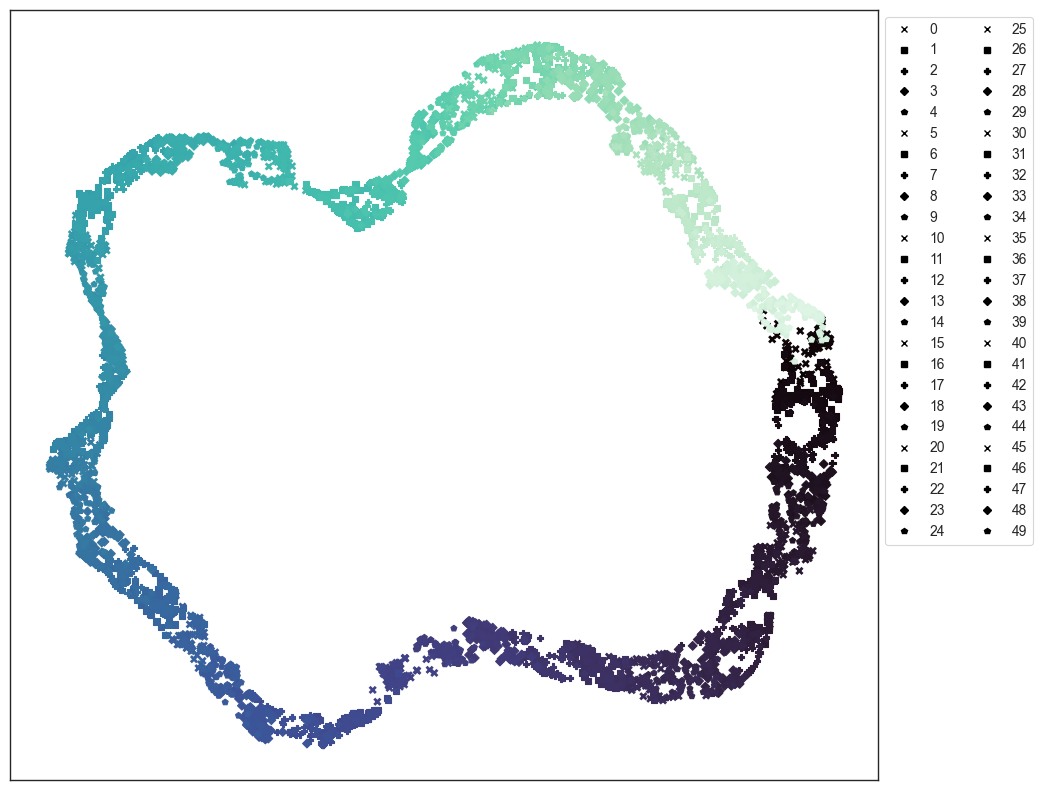

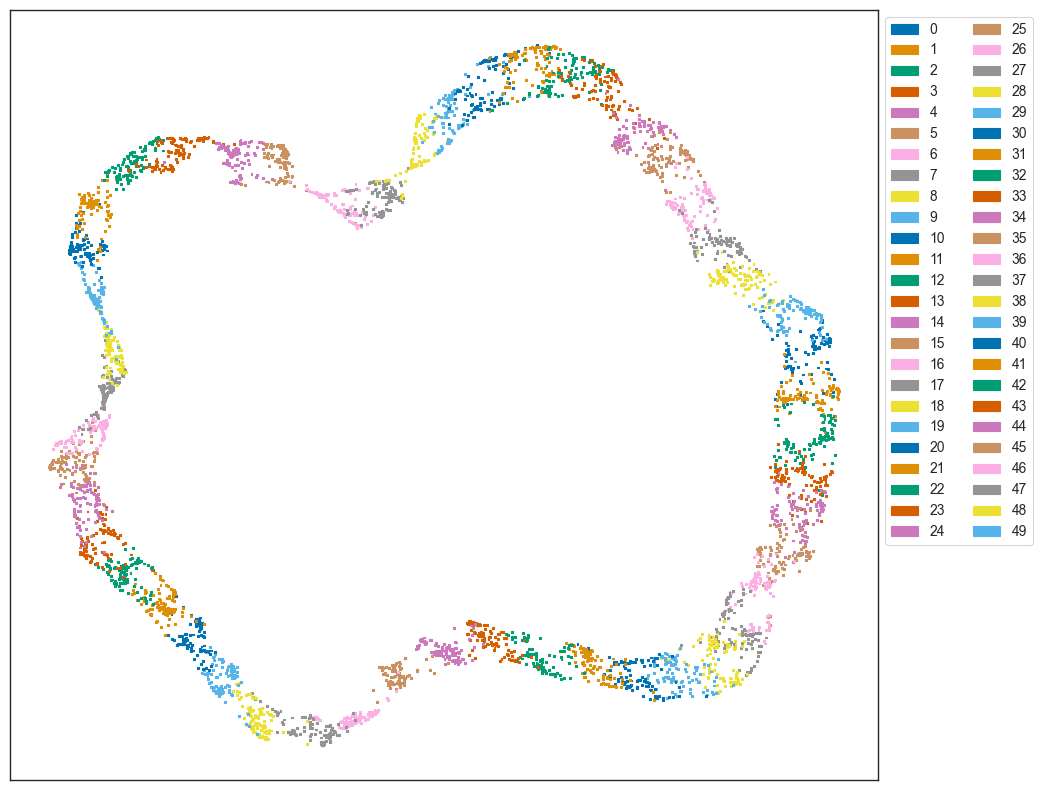

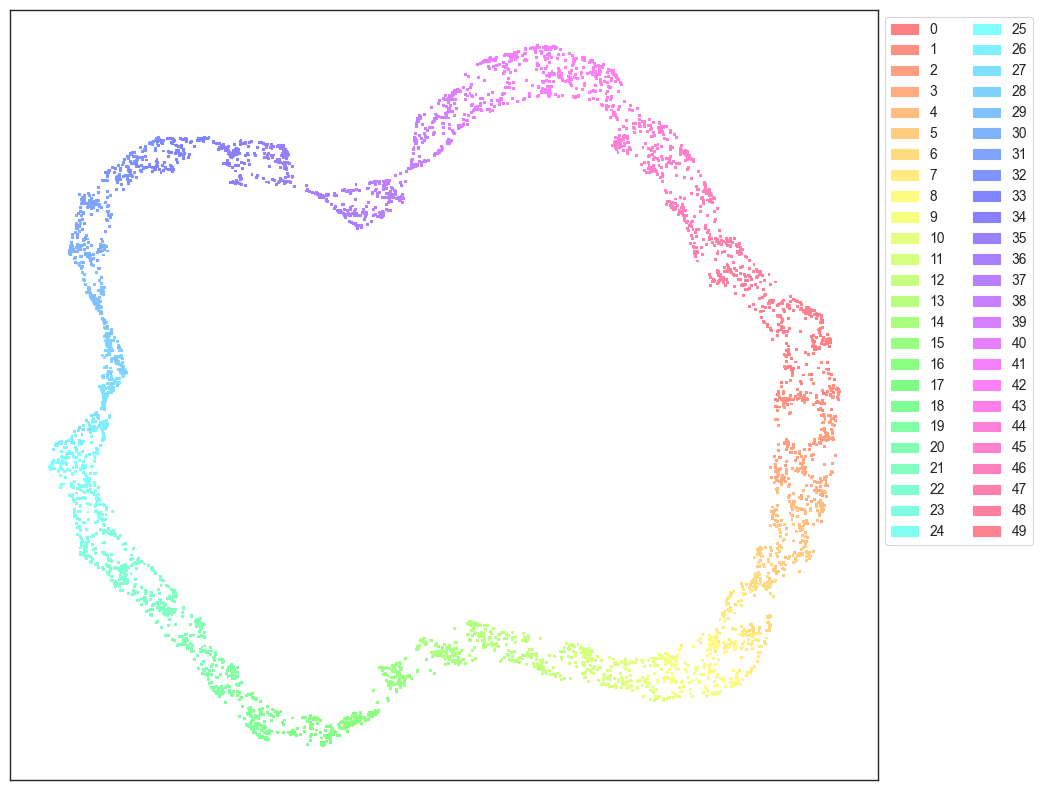

In [28]:
import pacmap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap
import matplotlib.lines as mlines

from matplotlib.colors import ListedColormap, hsv_to_rgb
import seaborn as sns


# create a custom pacmap plot
color_map = ListedColormap(sns.color_palette('colorblind', 50))
hsl_colors = [(i * (360 / 50), 50, 100) for i in range(50)]
#color_map = ListedColormap([hsv_to_rgb((hsl[0] / 360, hsl[1] / 100, hsl[2] / 100)) for hsl in hsl_colors])

#legend_patches = [Patch(color=color_map(i / n_classes), label=label) for i, label in enumerate(class_labels)]
# save the visualization result
embedding = pacmap.PaCMAP(n_components=2)
X_transformed = embedding.fit_transform(features_test.cpu().numpy(), init="pca")
fig, ax = plt.subplots(1, 1, figsize=[14,10], facecolor='w', edgecolor='k')

labels = labels_test.cpu().numpy()
time_labels = np.arange(0, len(labels), 1)
time_colormap = ListedColormap(sns.color_palette("mako", len(labels),))
# we know that in this specific version of the testset there are 100 images per class

marker_list = ["x", "s", "P", "D", "p"]*10
for i in range(50):
    print(i*split,(i+1)*split)
    split=100
    ax.scatter(X_transformed[i*split:(i+1)*split, 0], X_transformed[i*split:(i+1)*split, 1], 
# c=,
s=20.,
marker=marker_list[i],
#facecolors='none',
c=time_colormap(time_labels)[i*split:(i+1)*split],
)

    
#ax.set_title('Pacmap Plot')
plt.xticks([]), plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend_patches = [mlines.Line2D([], [], color='black', marker=marker_list[i], linestyle='None',
                          markersize=4, label=i) for i in range(50)]

ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), handles=legend_patches, fontsize=10, ncol=2)
#ax.colorbar()
#legend(loc=2, prop={'size': 6})
# ax.text(-0.15, 1.05, 'C', transform=ax.transAxes, size=30, weight='medium')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=[14,10], facecolor='w', edgecolor='k')
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color_map(labels), s=2., marker='s')
#ax.set_title('Pacmap Plot')
plt.xticks([]), plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend_patches = [Patch(color=color_map(i), label=label) for i, label in enumerate(data_properties_dict[args.dataset].classes)]
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), handles=legend_patches, fontsize=10, ncol=2)

plt.show()


color_map = ListedColormap([hsv_to_rgb((hsl[0] / 360, hsl[1] / 100, hsl[2] / 100)) for hsl in hsl_colors])

fig, ax = plt.subplots(1, 1, figsize=[14,10], facecolor='w', edgecolor='k')
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color_map(labels), s=2., marker='s')
#ax.set_title('Pacmap Plot')
plt.xticks([]), plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend_patches = [Patch(color=color_map(i), label=label) for i, label in enumerate(data_properties_dict[args.dataset].classes)]
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), handles=legend_patches, fontsize=10, ncol=2)

plt.show()



In [36]:
path_to_tmp_evaluation = args.exp_dir + "/tmp/"
os.makedirs(path_to_tmp_evaluation, exist_ok=True)
# write config to a json file
save_args(path_to_tmp_evaluation, args.__dict__)

conf_mat = ConfusionMatrix(n_cls=data_properties_dict[args.dataset].n_classes)
# tensorboard writer
writer = SummaryWriter(log_dir=path_to_tmp_evaluation)

#for layer, out_dim in zip([l3, l2, l1, l0],[84,400,1176,3072]):
for layer, out_dim in zip([l0],[3072]):

    train_loss, train_acc, test_loss, test_acc, = train_linear_classifier(
    dataloader_train_eval,
    dataloader_test,
    out_dim,
    data_properties_dict[args.dataset].n_classes,
    model=layer,
    confusion_matrix=conf_mat,
    epochs=200,#args.linear_nn_epochs,
    timestep=100,#epoch + 1,
    test_every=1,#args.linear_nn_test_every,
    writer=writer,
    device=device)
    print(train_loss, train_acc, test_loss, test_acc)


[INFO:] Starting linear evaluation with Neural Network at epoch 101


Loss:   1.4984: 100%|█████████████████████████| 200/200 [13:38<00:00,  4.09s/it]

0.9081822752952575 0.6768666666666666 1.4983672990518457 0.4216


0.0 1.0


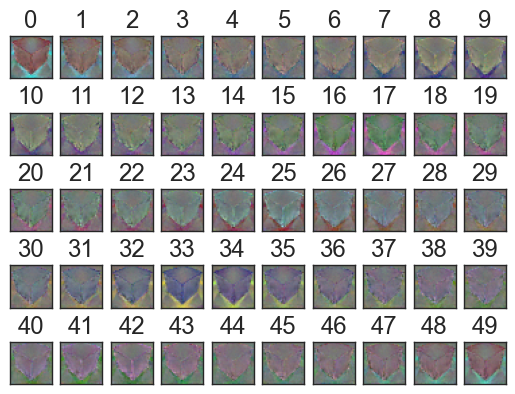

In [37]:
import matplotlib.pyplot as plt
#reload the last trained classifier (raw input)
classifier_path = path_to_tmp_evaluation + '/models/'+'classifier_epoch_100.pt'
classifier = LinearClassifier(num_features=3072)
load_model(classifier, classifier_path, device)
#model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
classifier.eval()


# visualize weights in RGB
weights = classifier.linear_out[1].weight.to('cpu').detach().numpy().reshape(50,3,32,32)
weights -= weights.min()
weights /= weights.max()
print(weights.min(), weights.max())
weights = weights[:,:,:,:]
for i in range(50):
    plt.subplot(5, 10, i+1)
    weight = weights[i,:,:,:]
    weight = np.moveaxis(weight, 0, -1)

    plt.title(i)
    plt.imshow(weight)
    #plt.matshow(weight)
    #plt.clim(weights.min(), weights.max())  # as noted by @Eric Duminil, cmap='gray' makes the numbers stand out more
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

## 2. Load Tensorboard Logs to redraw learning curves